<a href="https://colab.research.google.com/github/alistairewj/process-biases-in-mimic/blob/main/analyze/primary_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primary analysis

**Study title**: Biases in electronic health record data due to processes within
the healthcare system: retrospective observational study

**DOI**: http://dx.doi.org/10.1136/bmj.k1479

This notebook reproduces the final analysis of the above study.

**The objective of the study was**: To evaluate on a large scale, across 272 common
types of laboratory tests, the impact of healthcare
processes on the predictive value of electronic health
record (EHR) data.

## Import libraries

In [13]:
# Import libraries
import os
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# local package - can be useful to put misc utilities into a file in the same folder
# import utils

Next we load in the generated tables.

In [2]:
# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# You only need to authenticate once per session.
auth.authenticate_user()

In [3]:
# Set up environment variables
project_id = 'kind-lab'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
    return pd.io.gbq.read_gbq(
        query,
        project_id=project_id,
        dialect="standard"
    )

In [4]:
cohort = run_query("select * from `kind-lab.process_bias.cohort`")
cohort.set_index('hadm_id', inplace=True)

mortality = run_query("select * from `kind-lab.process_bias.mortality`")
wbc = run_query("select * from `kind-lab.process_bias.wbc`")
wbc.head()

,hadm_id,specimen_id,wbc_value,wbc_abnormal,wbc_time_of_day,prev_specimen_id,wbc_prev_value,wbc_prev_abnormal,wbc_prev_time_of_day
0,28909605.0,59930619,14.3,1,7.766666667,11488691.0,15.3,1,3.5
1,21627054.0,59186708,12.0,1,4.3,26527934.0,9.6,0,2.633333333
2,23975676.0,51854832,12.9,1,8,65177701.0,10.6,0,3.983333333
3,26436502.0,7929057,12.5,1,6,46220635.0,17.8,1,22
4,20388936.0,82698012,0.1,1,0,32144456.0,0.1,1,0.383333333


## Exclusions


Apply exclusions. Below function may be useful in printing out exclusions.

In [9]:
def get_exclusions(df, verbose=True):
    """
    Get all exclusions, assuming columns begin with the word exclusion.
    
    Returns an index of stays to *keep* in the study.
    """
    N = df.shape[0]
    idx = df.index.notnull()
    cols = [c for c in df.columns if c.startswith('exclusion')]

    if verbose:
        print(f'{N} stays')

    # remove excluded patients
    for c in cols:
        idxExcl = df[c] == 1
        n_excl = (idx & idxExcl).sum()
        frac = n_excl / N * 100.0
        if verbose:
            print(f'  {n_excl:5d} / {N:5d} ({frac:3.1f}%) - {c}')
        idx = idx & ~idxExcl
        N = idx.sum()
    
    return idx

In [29]:
idx = get_exclusions(cohort)
# create a "co" dataframe with only the hadm_id we intend to keep
co = cohort.loc[idx, []].copy().reset_index()
print(co.shape)
co.head()

454324 stays
      0 / 454324 (0.0%) - exclusion_unknown_sex
      0 / 454324 (0.0%) - exclusion_unknown_age
  12753 / 454324 (2.8%) - exclusion_older_than_89
  339555 / 441571 (76.9%) - exclusion_outside_cohort
(102016, 1)


,hadm_id
0,27744664
1,26034097
2,21929349
3,25187061
4,25736370


## Preprocess

Process and merge dataframes into a final study dataframe.

In [33]:
# create the df dataframe for plotting

# apply exclusion criteria to wbc
df = co.merge(wbc, how='inner', on='hadm_id')
# get one-year mortality
df = df.merge(mortality[['hadm_id', 'one_year_mortality']], on='hadm_id', how='inner')
df['one_year_survival'] = 1 - df['one_year_mortality']

# create an abnormal flag, grouping WBC values into low/normal/high
df['abnormal_flag'] = 'Normal'

idx = (df['wbc_abnormal'] == 1) & (df['wbc_value'] < 7)
df.loc[idx, 'abnormal_flag'] = 'Low'
idx = (df['wbc_abnormal'] == 1) & (df['wbc_value'] > 7)
df.loc[idx, 'abnormal_flag'] = 'High'

## Analyze

Apply the analysis method.


## Results

Print tables / figures / statements summarizing the results in a similar manner to the original study.

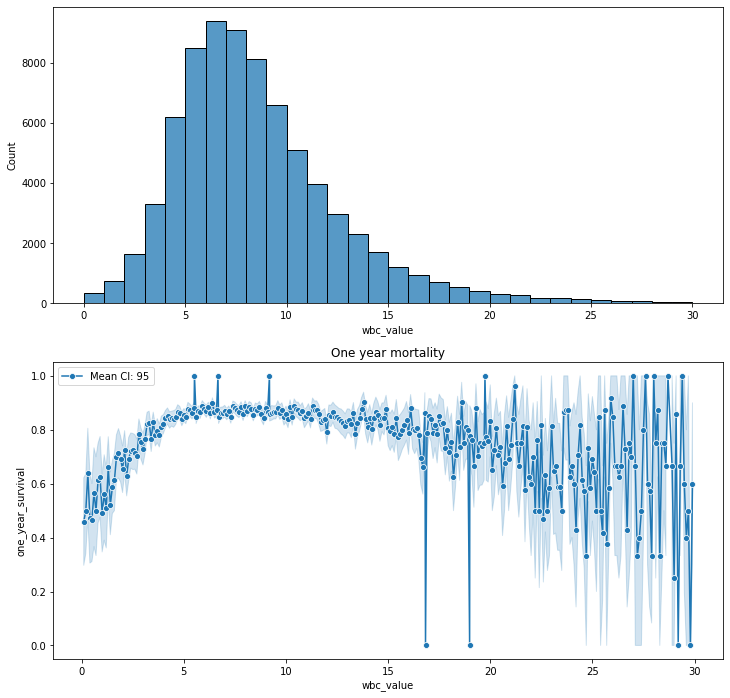

In [31]:
# plots
df.sort_values(['wbc_value'], ascending=True, inplace=True)
idx = df['wbc_value'] < 30

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 12))
sns.histplot(data=df.loc[idx], x="wbc_value", ax=ax1, bins=np.linspace(0, 30, 31))
sns.lineplot(data=df.loc[idx], x="wbc_value", y="one_year_survival", marker='o', ci=95, ax=ax2, label='Mean CI: 95')
ax2.set(title='One year mortality')
plt.show()

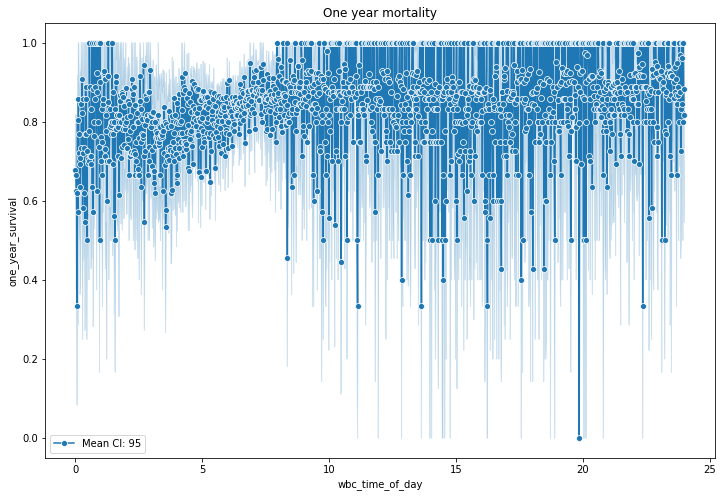

In [32]:
# plots
df.sort_values(['wbc_time_of_day'], ascending=True, inplace=True)
fig, (ax1) = plt.subplots(nrows=1, figsize=(12, 8))
sns.lineplot(data=df.loc[idx], x="wbc_time_of_day", y="one_year_survival", marker='o', ci=95, ax=ax1, label='Mean CI: 95')
ax1.set(title='One year mortality')
plt.show()

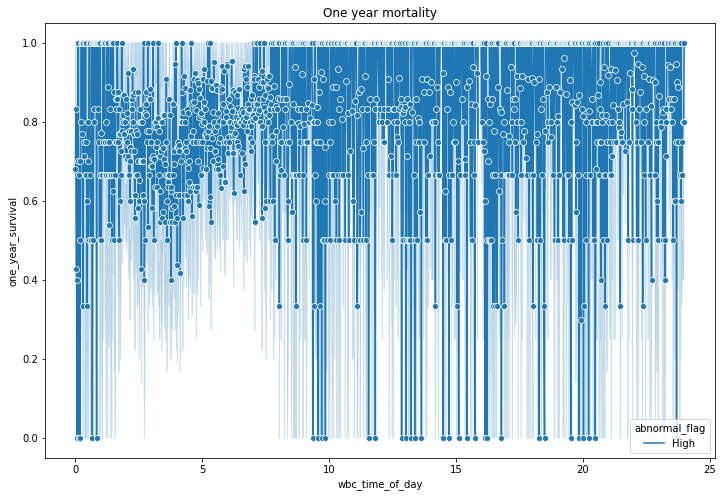

In [36]:
# plots
df.sort_values(['wbc_time_of_day'], ascending=True, inplace=True)
fig, (ax1) = plt.subplots(nrows=1, figsize=(12, 8))
sns.lineplot(data=df.loc[idx], x="wbc_time_of_day", y="one_year_survival", hue='abnormal_flag', marker='o', ci=95, ax=ax1)
ax1.set(title='One year mortality')
plt.show()